# Inference XGBoost Regression from ALL

In [114]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from pathlib import Path
import xgboost as xgb
import numpy as np
import pickle

In [145]:
data_dir = "../../preprocessed/" 
features_dir = data_dir + "regression_features/features_all/"
# labels_dir = data_dir + "labels/" 
separate_features_dir = data_dir + "regression_features/features_separate_cities/"

model_dir = "../../resources/regression/" 

standardize_features = True

PCA_components = 64

USE_GEO = "GEO"

if USE_GEO == "GEO":
    features_columns = ["PCA"+str(i) for i in range(PCA_components)] + \
                        ["centroid_x", "centroid_y"]
else:
    features_columns = ["PCA"+str(i) for i in range(PCA_components)]
        

network_type = "vgg16_4096"


standardize_features = True

CITY = "roma"

# feature_size = 2048

In [146]:
label_columns = ["hType_mix", "num_intersect", "bld_avg_age", "emp_rat_num",\
				"LUM5_single",	"RNR_nres", "mdist_smallparks", "nig_rat_daily",\
				"nig_rat_daily3", "mdist_nres_daily", "num_community_places", \
				"num_community_places_poi", "avg_block_area", "sphi", \
				"enterprises_empl_size", "pop_rat_num",  \
				"emp_rat_pop", "den_nres_daily",\
				"mdist_parks", "den_nres_non-daily", "mdist_railways",\
				"mdist_highways", "mdist_water", "activity_density"] # "bld_rat_area", 

In [147]:
land_use = [
"LUM5_single","RNR_nres","mdist_smallparks",
"hType_mix", "nig_rat_daily", "mdist_nres_daily",
"num_community_places", "num_community_places_poi"]


small_blocks = [
"avg_block_area","num_intersect", "sphi"]


age_buildings = [
"bld_avg_age","enterprises_empl_size"]

concentration = [
"pop_rat_num","emp_rat_num","emp_rat_pop"
    ,"den_nres_daily","den_nres_non-daily"]

vacuums = [
"mdist_parks", "mdist_railways",
"mdist_highways", "mdist_water"]

## Functions

In [148]:
if network_type == "vgg19":
	features_file = "Italy_6_cities_vgg19_pca"+str(PCA_components)+"_linear_fc_thirdlast_layer.csv"
elif network_type == "resnet50":
	features_file = "Italy_6_cities_resnet_pca"+str(PCA_components)+"_second_last_layer.csv"
elif network_type == "vgg16_4096":
	features_file = "Italy_6_cities_resnet_pca" + str(PCA_components) + "_vgg16_4096.csv"

In [149]:
def get_normalized_labels_features(city_name=CITY):

    df = pd.read_csv(separate_features_dir + \
        features_file.replace(".csv", "_" + city_name + "_labels_features.csv"))

    df["city_image"] = df.\
        apply(lambda x: x.city + "_" + x.imageName, axis = 1)
    
    del df['imageName']
    del df['city']
    del df['index']
    return df

In [160]:
def infer_label_i(label="label_hType_mix"):
    
    data2 = data.copy()
    target = data2[["city_image", label]]
    features = data2[features_columns]
    
    X = features.values
    y = target[label].values
    
    clf = pickle.load(open(model_dir + label + '_all_reg.dat', 'rb'))
    
    predictions = clf.predict(X) 
    
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r2 = r2_score(y, predictions)
    mae = mean_absolute_error(y, predictions)
       
    return  ({"MAE": mae, "R2": r2, "RMSE": rmse})

## Read in Data. Chose standardized or not.

In [161]:
data = get_normalized_labels_features()

## Predict K-Fold

In [162]:
data[['label_activity_density']].describe()

,label_activity_density
count,1056.000000
mean,0.393545
std,0.225134
min,0.000000
25%,0.241655
50%,0.324620
75%,0.533174
max,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b0c2ad0>]],
      dtype=object)

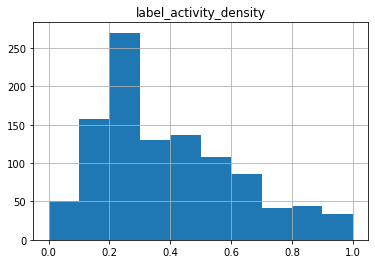

In [163]:
data[['label_activity_density']].hist()

In [164]:
len(data)

1056

In [165]:
infer_label_i('label_activity_density')

{'MAE': 0.17346616734853704,
 'R2': 0.15334382953112236,
 'RMSE': 0.20705685285260136}

In [166]:
SCORES = {}
for col in label_columns:
    label = "label_" + col
    res = infer_label_i(label)
    SCORES[label] = res

In [167]:
SCORES

{'label_hType_mix': {'MAE': 0.21271542868343338,
  'R2': -1.4179867277621718,
  'RMSE': 0.24336562456455277},
 'label_num_intersect': {'MAE': 0.17012434710960447,
  'R2': 0.06692024326153401,
  'RMSE': 0.2154930488488831},
 'label_bld_avg_age': {'MAE': 0.17162071726456685,
  'R2': 0.15724176848322913,
  'RMSE': 0.21522434809438948},
 'label_emp_rat_num': {'MAE': 0.16017188794233117,
  'R2': 0.13715675924190263,
  'RMSE': 0.19604607057876458},
 'label_LUM5_single': {'MAE': 0.23816928959912623,
  'R2': -0.19672943577699176,
  'RMSE': 0.282984139571359},
 'label_RNR_nres': {'MAE': 0.2626781327207859,
  'R2': -0.28241133916454686,
  'RMSE': 0.3262536369974883},
 'label_mdist_smallparks': {'MAE': 0.15926768834020263,
  'R2': 0.17318742304648382,
  'RMSE': 0.19637177719057997},
 'label_nig_rat_daily': {'MAE': 0.15324560492159006,
  'R2': -0.7343853853062412,
  'RMSE': 0.19549675955592308},
 'label_nig_rat_daily3': {'MAE': 0.0809002013004022,
  'R2': -0.7092096466010314,
  'RMSE': 0.129354662

In [168]:
res = pd.DataFrame(SCORES)

In [169]:
res

,label_hType_mix,label_num_intersect,label_bld_avg_age,label_emp_rat_num,label_LUM5_single,label_RNR_nres,label_mdist_smallparks,label_nig_rat_daily,label_nig_rat_daily3,label_mdist_nres_daily,...,label_enterprises_empl_size,label_pop_rat_num,label_emp_rat_pop,label_den_nres_daily,label_mdist_parks,label_den_nres_non-daily,label_mdist_railways,label_mdist_highways,label_mdist_water,label_activity_density
MAE,0.212715,0.170124,0.171621,0.160172,0.238169,0.262678,0.159268,0.153246,0.080900,0.169920,...,0.237520,0.170378,0.193370,0.200324,0.190805,0.156024,0.204384,0.220112,0.194415,0.173466
R2,-1.417987,0.066920,0.157242,0.137157,-0.196729,-0.282411,0.173187,-0.734385,-0.709210,0.049878,...,-0.037948,-0.194747,-0.520007,0.012483,-0.128111,-0.388631,-0.228889,-0.562431,-0.516684,0.153344
RMSE,0.243366,0.215493,0.215224,0.196046,0.282984,0.326254,0.196372,0.195497,0.129355,0.210762,...,0.277640,0.214289,0.233217,0.246496,0.241018,0.202397,0.250112,0.284195,0.242445,0.207057


In [14]:
if standardize_features:
    out_name = '../../results/XGBoost/ALL_XGBoost' +str(PCA_components)\
            + '_' + network_type + '_' + USE_GEO + '_standardized7s.csv'
else:
    out_name = '../../results/XGBoost/ALL_XGBoost' +str(PCA_components)\
       + '_' + network_type + '_' + USE_GEO +   '7s.csv'
res.to_csv(out_name, float_format='%.3f')

In [15]:
res_dir = '../../results/XGBoost/ALL_' + network_type + '_' + USE_GEO +"_" + str(PCA_components)
Path(res_dir).mkdir(parents=True, exist_ok=True)

In [16]:
land_use_cols = ["label_"+l for l in land_use]
res_land_use = res[land_use_cols]

In [17]:
small_blocks_cols = ["label_"+l for l in small_blocks]
res_small_blocks = res[small_blocks_cols]

In [18]:
age_buildings_cols = ["label_"+l for l in age_buildings]
res_age_buildings = res[age_buildings_cols]

In [19]:
concentration_cols = ["label_"+l for l in concentration]
res_concentration = res[concentration_cols]

In [20]:
vacuums_cols = ["label_"+l for l in vacuums]
res_vacuums = res[vacuums_cols]

In [21]:
for out_cat_name in ["land_use", "small_blocks", \
                     "age_buildings", "concentration",
                    "vacuums"]:
    eval("res_" + out_cat_name).to_csv(res_dir + "/res_" + out_cat_name+\
                                       ".csv", float_format='%.3f')